# Predicting house prices using Lasso + XGBoost

This was a Kaggle competition in which I competed in July 2018. The goal was to predict the price of a house given 79 features in various formats. This was a good combination of data cleaning, feature exploration, and parameter tuning. My final score was 0.12093, which put me in the top 20% of ~5000 entrants.

In [11]:
#Importing the standard data science workhorses

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

import matplotlib.pyplot as plt #visualization

import os

In [7]:
#Reading in train and test sets
trainDf = pd.read_csv('~/Kaggle/House Pricing/train.csv')
testDf = pd.read_csv('~/Kaggle/House Pricing/test.csv')

In [8]:
#First pass at data cleaning - removing numerical outliers

numDf = trainDf.select_dtypes(exclude=['object'])
outliers = numDf[numDf.apply(lambda x: np.abs(x-x.mean())/x.std() > 5)]
outlierList = []
for col in outliers.columns:
    outlierCol = outliers.loc[np.isnan(outliers[col])==False]
    if len(outlierCol) > 0:
        #print(col, len(outlierCol), outlierCol.index)
        for x in list(outlierCol.index):
            outlierList.append(x)

In [9]:
trainDf = trainDf.drop(trainDf.index[outlierList])

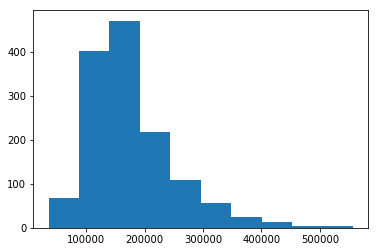

In [58]:
#First off, let's see our distribution of sale price. Looks pretty lognormal! We'll come back to this when we
#start fitting
plt.hist(trainDf['SalePrice'])
plt.show()

In [55]:
#Lot frontage is likely to be a key explanatory variable, and it has a good amount of missing data. We should
#handle those values carefully.
print(len(trainDf),len(trainDf.loc[np.isnan(trainDf['LotFrontage'])]))

1370 241


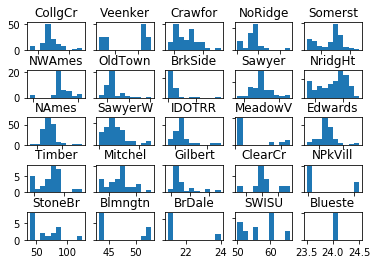

In [59]:
#Visualizing lot frontage - it looks like the distribution is highly dependent on neighborhood.
#We should control for this. For now let's make a groupby object grouping lot frontage by neighborhood.
#We'll come back to this in a bit
f, axarr = plt.subplots(5,5)
for i, j in enumerate(trainDf['Neighborhood'].unique()):
    tmp = trainDf.loc[trainDf['Neighborhood'] == j]
    axarr[int(i/5), i%5].hist(tmp['LotFrontage'].dropna())
    axarr[int(i/5), i%5].set_title(str(j))
    
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_xticklabels() for a in axarr[1, :]], visible=False)
plt.setp([a.get_xticklabels() for a in axarr[2, :]], visible=False)
plt.setp([a.get_xticklabels() for a in axarr[3, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 2]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 3]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 4]], visible=False)

f.subplots_adjust(hspace=0.7)

plt.show()

In [44]:
lotFrontByNeighborhood = trainDf['LotFrontage'].groupby(trainDf['Neighborhood'])

In [43]:
#Factorizing categorical variables - encoding them to ordinal numbers. Helps with fitting.

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def factorize(df, factorDf, col, fill_na=None):
    factorDf[col] = df[col]
    if fill_na is not None:
        factorDf[col].fillna(fill_na, inplace = True)
    le.fit(factorDf[col].unique())
    factorDf[col] = le.transform(factorDf[col])
    return factorDf

In [40]:
#Let's also look at median sale price per neighborhood - we can turn this into a feature as well
trainDf.groupby('Neighborhood')['SalePrice'].median()

Neighborhood
Blmngtn    186000.0
Blueste    137500.0
BrDale     106000.0
BrkSide    127000.0
ClearCr    190000.0
CollgCr    195950.0
Crawfor    189950.0
Edwards    118750.0
Gilbert    181000.0
IDOTRR     108000.0
MeadowV     87000.0
Mitchel    153500.0
NAmes      140000.0
NPkVill    146000.0
NWAmes     181000.0
NoRidge    290000.0
NridgHt    311906.5
OldTown    117000.0
SWISU      139500.0
Sawyer     134950.0
SawyerW    179200.0
Somerst    225500.0
StoneBr    282000.0
Timber     226250.0
Veenker    190500.0
Name: SalePrice, dtype: float64

In [45]:
def prepData(df):
    #Output a new dataframe containing all our processed data
    outDf = pd.DataFrame(index=df.index)
    #Control for varied lot frontage by neighborhood - when there's a missing value, use the group median
    outDf['LotFrontage'] = df['LotFrontage']
    for key,group in lotFrontByNeighborhood:
        idx = (df['Neighborhood']==key) & (df['LotFrontage'].isnull())
        outDf.loc[idx, 'LotFrontage'] = group.median()
        
    #Insert numerical values, fill missing values with zero 
    #Next step for future - impute missing values with interpolated estimates
    colList = list(numDf.columns)
    colList.remove('SalePrice')
    for col in colList:
        outDf[col] = df[col]
        outDf[col].fillna(0, inplace=True)
        
    #Map Non numerical values - encode quality assessments like "Poor" and "Good" to ints
    outDf["CentralAir"] = (df["CentralAir"] == "Y") * 1.0
    
    qualDict = {None:0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
    outDf['ExterQual'] = df['ExterQual'].map(qualDict).astype(int)
    outDf['ExterCond'] = df['ExterCond'].map(qualDict).astype(int)
    outDf["GarageQual"] = df["GarageQual"].map(qualDict).astype(int)
    outDf["GarageCond"] = df["GarageCond"].map(qualDict).astype(int)    
    outDf["BsmtQual"] = df["BsmtQual"].map(qualDict).astype(int)
    outDf["BsmtCond"] = df["BsmtCond"].map(qualDict).astype(int)
    outDf["KitchenQual"] = df["KitchenQual"].map(qualDict).astype(int)
    outDf["HeatingQC"] = df["HeatingQC"].map(qualDict).astype(int)    
    outDf["FireplaceQu"] = df["FireplaceQu"].map(qualDict).astype(int)


    outDf["BsmtExposure"] = df["BsmtExposure"].map(
        {None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

    bsmt_fin_dict = {None: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    outDf["BsmtFinType1"] = df["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
    outDf["BsmtFinType2"] = df["BsmtFinType2"].map(bsmt_fin_dict).astype(int)
    outDf["Fence"] = df["Fence"].map(
        {None: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)
    outDf["GarageFinish"] = df["GarageFinish"].map(
        {None: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)
    outDf["Functional"] = df["Functional"].map(
        {None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)
    
    outDf["PoolQC"] = df["PoolQC"].map(qualDict).astype(int)
    
    
    #Factorize all other categorical values
    outDf = factorize(df, outDf, "Neighborhood")    
    outDf = factorize(df, outDf, "Exterior1st", "Other")
    outDf = factorize(df, outDf, "Exterior2nd", "Other")    
    outDf = factorize(df, outDf, "MSSubClass")
    outDf = factorize(df, outDf, "MSZoning", "RL")
    outDf = factorize(df, outDf, "MasVnrType", "None")   
    outDf = factorize(df, outDf, "LotConfig")
    outDf = factorize(df, outDf, "Condition1")
    outDf = factorize(df, outDf, "BldgType")
    outDf = factorize(df, outDf, "HouseStyle")
    outDf = factorize(df, outDf, "RoofStyle")
    outDf = factorize(df, outDf, "Foundation")
    outDf = factorize(df, outDf, "SaleCondition")    
    outDf = factorize(df, outDf, "SaleType", "Oth")

    
    #Encode neighborhoods to ints based on median price
    neighborhoodMap = {
        "MeadowV" : 0,  #  87000
        "BrDale" : 1,   # 106000
        "IDOTRR" : 1,   # 108000
        "OldTown" : 1,  # 117000
        "Edwards" : 1,  # 118750
        "BrkSide" : 1,  # 127000
        "Sawyer" : 1,   # 134950
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179200
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 181000
        "Blmngtn" : 3,  # 186000
        "Crawfor" : 3,  # 189950        
        "ClearCr" : 3,  # 190000        
        "Veenker" : 3,  # 190500
        "CollgCr" : 3,  # 195950
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 226250
        "StoneBr" : 4,  # 282000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 311907
    }
    
    outDf['NeighborhoodBin'] = df['Neighborhood'].map(neighborhoodMap)
    return outDf
    
    
        

In [46]:
#Process our train and test sets
preppedTrainDf = prepData(trainDf)
preppedTestDf = prepData(testDf)

In [56]:
print(preppedTrainDf.shape, preppedTestDf.shape)

(1370, 68) (1459, 68)


In [ ]:
#Let's try Lasso regression as a first pass. Lasso is a great, simple way to counter overfitting. It imposes
#L1 regularization by imposing an additional penalty to the cost function that's linear in the number of parameters.

In [71]:
from sklearn.linear_model import Lasso

In [72]:
#Let's use the log of sale price - remember our distribution looked lognormal so taking the log should
#transform it to look more like a normal distribution and make it more conducive to regression
labelDf = pd.DataFrame(index = preppedTrainDf.index, columns=['SalePrice'])
labelDf['SalePrice'] = np.log(trainDf['SalePrice'])



In [79]:
#Let's use grid search to handle cross validation and pick out the optimal value of alpha

In [73]:
lassoGrid = Lasso()
from sklearn.model_selection import GridSearchCV
parameters = {'alpha':[x/100000 for x in range(500)], 'max_iter':[50000]}
myGrid = GridSearchCV(lassoGrid, parameters)

In [74]:
myGrid.fit(preppedTrainDf, labelDf)
print(myGrid.best_estimator_)

/Users/ajohnson/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/ajohnson/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ajohnson/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ajohnson/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_tr

Lasso(alpha=0.00049, copy_X=True, fit_intercept=True, max_iter=50000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


In [75]:
#Looks like 0.00049 is our best candidate. Let's go ahead and fit with it.
regr = Lasso(alpha = 0.00049, max_iter = 50000)
regr.fit(preppedTrainDf, labelDf)

Lasso(alpha=0.00049, copy_X=True, fit_intercept=True, max_iter=50000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [76]:
#Predicting sale prices from fit
y_pred = regr.predict(preppedTrainDf)
y_test =labelDf['SalePrice']

In [77]:
#Function for root mean squared error
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [78]:
#RMSE of ~10% is not too bad for now
print(rmse(y_test, y_pred))

0.106987910301


In [80]:
#Make our prediction on the test set
lassoPred = regr.predict(preppedTestDf)

In [81]:
#Now let's try xgBoost. XGBoost uses the popular gradient boosting algorithm which uses a series of individual
#regressor trees to score inputs while adding subsequent trees which predict the residuals from previous trees
#and then combines the results into a final prediction
#(see https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-HowItWorks.html)

In [ ]:
import xgboost as xgb

In [ ]:
xgbRegr = xgb.XGBRegressor()

In [ ]:
#Let's use grid search again - now we have many more parameters to optimize!

xgParams = {'colsample_bytree':[x/10. for x in range(10)], 
            'gamma':[x/10. for x in range(10)],
           'learning rate':[x/100. for x in range(10)],
           'max_depth':[1,2,3,4,5],
           'min_child_weight':[0, 0.5, 1, 1.5, 2, 2.5],
           'n_estimators':[x*100. for x in range(100)],
           'reg_alpha':[x/10. for x in range(10)],
           'reg_lambda':[x/10. for x in range(10)],
           'subsample':[x/10. for x in range(10)],
           'random_state':[x for x in range(100)],
           'silent':[1]}

In [ ]:
xgbGrid = GridSearchCV(xgbRegr, xgParams)

In [ ]:
xgbGrid.fit(preppedTrainDf, labelDf)

In [ ]:
#Running xgb with optimized parameters
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(preppedTrainDf, labelDf)

In [ ]:
xgbPred = regr.predict(preppedTrainDf)
xgbTest = labelDf

In [ ]:
rmse(xgbTest, xgbPred)

In [ ]:
xgbTestPred = regr.predict(preppedTestDf)

In [ ]:
#Average the results from our Lasso model and our XGBoost model
submitPred = (lassoPred + xgbTestPred)/2

In [ ]:
#Remember to transform back to housing prices since we took the log!
submission = np.exp(submitPred)

In [ ]:
predDf = pd.DataFrame(submission, index=preppedTestDf['Id'], columns=['SalePrice'])
predDf.to_csv('output.csv',header=True, index_label='Id')